In [1]:
!git clone -b week9-dev https://github.com/vamsigp/EVA5/

Cloning into 'EVA5'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 421 (delta 12), reused 28 (delta 4), pack-reused 379
Receiving objects: 100% (421/421), 47.06 MiB | 17.13 MiB/s, done.
Resolving deltas: 100% (207/207), done.


In [2]:
%cd EVA5/trainer

/content/EVA5/trainer


In [3]:
!pip install -U albumentations

     |████████████████████████████████| 122kB 8.1MB/s 
     |████████████████████████████████| 952kB 8.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=71f0ed3802afb603a9532f9a6733325f652ccefb733561f0480362c9f55b8cd5
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
%matplotlib inline

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from config import ModelConfig
from data_engine import DataEngine
from trainer import Trainer
from results import *
from utils import *

In [6]:
from Albumentations import *
from GradCAM import *

In [7]:
# from models.cifar10 import cifar10Model
from models.resnet import ResNet18

In [8]:
transform_album = album_compose()

In [9]:
# View model config
args = ModelConfig(transform_album)
args.print_config()

print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout_value': 0.15,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1,
  'train_transform': <Albumentations.album_compose object at 0x7faac45bfbe0>}

CUDA Available


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


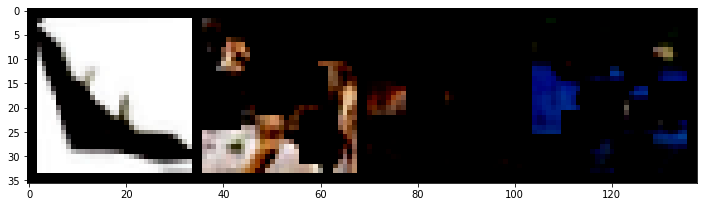

In [10]:
data = DataEngine(args)

# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

In [11]:
device = which_device()
# model = Net(args).to(device)
model = ResNet18().to(device)
# model = cifar10Model().to(device)
show_model_summary(model, device, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [12]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
# scheduler = OneCycleLR(optimizer,max_lr=0.1,total_steps=20)

In [14]:
trainer = Trainer(model, 
                  device,
                  train_loader=data.train_loader, 
                  test_loader = data.test_loader, 
                  optimizer = optimizer, 
                  loss_func = criterion, 
                  lr_scheduler = scheduler) 

In [15]:
# (train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=args.epochs, lambda_l1=0.0001)
(train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=args.epochs, lambda_l1=0.0001)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/782 [00:00<?, ?it/s]

Current EPOCH: 0 last LR= [0.001] LR =  [0.001]


Train set: Loss=11.161491394042969 Batch_id=781 Accuracy=40.71: 100%|██████████| 782/782 [01:11<00:00, 10.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 5269/10000 (52.69%)

Current EPOCH: 1 last LR= [0.001] LR =  [0.001]


Train set: Loss=10.68497085571289 Batch_id=781 Accuracy=54.58: 100%|██████████| 782/782 [01:11<00:00, 10.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 5858/10000 (58.58%)

Current EPOCH: 2 last LR= [0.001] LR =  [0.001]


Train set: Loss=9.430229187011719 Batch_id=781 Accuracy=61.63: 100%|██████████| 782/782 [01:11<00:00, 10.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 6823/10000 (68.23%)

Current EPOCH: 3 last LR= [0.001] LR =  [0.001]


Train set: Loss=8.523634910583496 Batch_id=781 Accuracy=66.67: 100%|██████████| 782/782 [01:11<00:00, 10.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 7055/10000 (70.55%)

Current EPOCH: 4 last LR= [0.001] LR =  [0.001]


Train set: Loss=7.890864849090576 Batch_id=781 Accuracy=70.13: 100%|██████████| 782/782 [01:11<00:00, 10.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Accuracy: 7571/10000 (75.71%)

Current EPOCH: 5 last LR= [0.001] LR =  [0.001]


Train set: Loss=6.880049705505371 Batch_id=781 Accuracy=72.19: 100%|██████████| 782/782 [01:11<00:00, 10.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 7677/10000 (76.77%)

Current EPOCH: 6 last LR= [0.001] LR =  [0.001]


Train set: Loss=6.23276424407959 Batch_id=781 Accuracy=74.41: 100%|██████████| 782/782 [01:11<00:00, 10.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 7826/10000 (78.26%)

Current EPOCH: 7 last LR= [0.001] LR =  [0.001]


Train set: Loss=6.055043697357178 Batch_id=781 Accuracy=75.83: 100%|██████████| 782/782 [01:11<00:00, 10.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 7858/10000 (78.58%)

Current EPOCH: 8 last LR= [0.0001] LR =  [1e-05]


Train set: Loss=5.588585376739502 Batch_id=781 Accuracy=81.34: 100%|██████████| 782/782 [01:11<00:00, 10.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8431/10000 (84.31%)

Current EPOCH: 9 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=5.277645111083984 Batch_id=781 Accuracy=82.69: 100%|██████████| 782/782 [01:11<00:00, 10.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 8523/10000 (85.23%)

Current EPOCH: 10 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=5.454643726348877 Batch_id=781 Accuracy=83.54: 100%|██████████| 782/782 [01:11<00:00, 10.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 8505/10000 (85.05%)

Current EPOCH: 11 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=5.198455810546875 Batch_id=781 Accuracy=83.82: 100%|██████████| 782/782 [01:11<00:00, 10.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 8532/10000 (85.32%)

Current EPOCH: 12 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=5.165996551513672 Batch_id=781 Accuracy=84.34: 100%|██████████| 782/782 [01:11<00:00, 10.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 8530/10000 (85.30%)

Current EPOCH: 13 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=5.0277299880981445 Batch_id=781 Accuracy=84.53: 100%|██████████| 782/782 [01:11<00:00, 10.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 8515/10000 (85.15%)

Current EPOCH: 14 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=5.039198398590088 Batch_id=781 Accuracy=84.98: 100%|██████████| 782/782 [01:11<00:00, 10.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 8557/10000 (85.57%)

Current EPOCH: 15 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=5.008370399475098 Batch_id=781 Accuracy=85.39: 100%|██████████| 782/782 [01:11<00:00, 10.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 8569/10000 (85.69%)

Current EPOCH: 16 last LR= [1e-05] LR =  [1.0000000000000002e-06]


Train set: Loss=4.9135847091674805 Batch_id=781 Accuracy=86.16: 100%|██████████| 782/782 [01:11<00:00, 10.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8608/10000 (86.08%)

Current EPOCH: 17 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=4.82647180557251 Batch_id=781 Accuracy=86.41: 100%|██████████| 782/782 [01:11<00:00, 10.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8622/10000 (86.22%)

Current EPOCH: 18 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=4.847179412841797 Batch_id=781 Accuracy=86.73: 100%|██████████| 782/782 [01:11<00:00, 10.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8665/10000 (86.65%)

Current EPOCH: 19 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=4.9878387451171875 Batch_id=781 Accuracy=86.66: 100%|██████████| 782/782 [01:11<00:00, 10.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8623/10000 (86.23%)

Current EPOCH: 20 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=4.952950954437256 Batch_id=781 Accuracy=86.86: 100%|██████████| 782/782 [01:11<00:00, 10.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8643/10000 (86.43%)

Current EPOCH: 21 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=5.13590145111084 Batch_id=781 Accuracy=86.96: 100%|██████████| 782/782 [01:11<00:00, 10.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8622/10000 (86.22%)

Current EPOCH: 22 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=4.825335502624512 Batch_id=781 Accuracy=86.75: 100%|██████████| 782/782 [01:11<00:00, 10.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8614/10000 (86.14%)

Current EPOCH: 23 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=5.142058372497559 Batch_id=781 Accuracy=87.07: 100%|██████████| 782/782 [01:11<00:00, 10.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8625/10000 (86.25%)

Current EPOCH: 24 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-07]


Train set: Loss=4.819149017333984 Batch_id=781 Accuracy=87.27: 100%|██████████| 782/782 [01:11<00:00, 10.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8637/10000 (86.37%)

Current EPOCH: 25 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-06]


Train set: Loss=4.865994453430176 Batch_id=781 Accuracy=87.12: 100%|██████████| 782/782 [01:11<00:00, 10.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8630/10000 (86.30%)

Current EPOCH: 26 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-06]


Train set: Loss=5.205601215362549 Batch_id=781 Accuracy=87.14: 100%|██████████| 782/782 [01:11<00:00, 10.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8648/10000 (86.48%)

Current EPOCH: 27 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-06]


Train set: Loss=4.906488418579102 Batch_id=781 Accuracy=87.19: 100%|██████████| 782/782 [01:11<00:00, 10.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8668/10000 (86.68%)

Current EPOCH: 28 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-06]


Train set: Loss=5.265313625335693 Batch_id=781 Accuracy=87.21: 100%|██████████| 782/782 [01:11<00:00, 10.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8653/10000 (86.53%)

Current EPOCH: 29 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-06]


Train set: Loss=5.209763050079346 Batch_id=781 Accuracy=87.20: 100%|██████████| 782/782 [01:11<00:00, 10.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8617/10000 (86.17%)

Current EPOCH: 30 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-06]


Train set: Loss=4.793018341064453 Batch_id=781 Accuracy=87.33: 100%|██████████| 782/782 [01:11<00:00, 10.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8639/10000 (86.39%)

Current EPOCH: 31 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-06]


Train set: Loss=4.622349739074707 Batch_id=781 Accuracy=87.11: 100%|██████████| 782/782 [01:11<00:00, 10.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8650/10000 (86.50%)

Current EPOCH: 32 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000004e-08]


Train set: Loss=4.678103923797607 Batch_id=781 Accuracy=87.33: 100%|██████████| 782/782 [01:11<00:00, 10.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8637/10000 (86.37%)

Current EPOCH: 33 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000002e-07]


Train set: Loss=4.868836402893066 Batch_id=781 Accuracy=87.26: 100%|██████████| 782/782 [01:11<00:00, 10.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8653/10000 (86.53%)

Current EPOCH: 34 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000002e-07]


Train set: Loss=4.833548069000244 Batch_id=781 Accuracy=87.16: 100%|██████████| 782/782 [01:11<00:00, 10.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8628/10000 (86.28%)

Current EPOCH: 35 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000002e-07]


Train set: Loss=4.736264228820801 Batch_id=781 Accuracy=87.30: 100%|██████████| 782/782 [01:11<00:00, 10.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8620/10000 (86.20%)

Current EPOCH: 36 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000002e-07]


Train set: Loss=4.91866397857666 Batch_id=781 Accuracy=87.18: 100%|██████████| 782/782 [01:11<00:00, 10.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8640/10000 (86.40%)

Current EPOCH: 37 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000002e-07]


Train set: Loss=4.870577812194824 Batch_id=781 Accuracy=87.19: 100%|██████████| 782/782 [01:11<00:00, 10.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8638/10000 (86.38%)

Current EPOCH: 38 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000002e-07]


Train set: Loss=4.944550514221191 Batch_id=781 Accuracy=87.24: 100%|██████████| 782/782 [01:11<00:00, 10.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8657/10000 (86.57%)

Current EPOCH: 39 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000002e-07]


Train set: Loss=4.699322700500488 Batch_id=781 Accuracy=87.11: 100%|██████████| 782/782 [01:11<00:00, 10.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8633/10000 (86.33%)

Current EPOCH: 40 last LR= [1.0000000000000004e-08] LR =  [1.0000000000000005e-09]


Train set: Loss=4.772188186645508 Batch_id=781 Accuracy=87.26: 100%|██████████| 782/782 [01:11<00:00, 10.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8643/10000 (86.43%)

Current EPOCH: 41 last LR= [1.0000000000000004e-08] LR =  [1.0000000000000004e-08]


Train set: Loss=4.94868803024292 Batch_id=781 Accuracy=87.42: 100%|██████████| 782/782 [01:11<00:00, 10.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8649/10000 (86.49%)

Current EPOCH: 42 last LR= [1.0000000000000004e-08] LR =  [1.0000000000000004e-08]


Train set: Loss=4.614746570587158 Batch_id=781 Accuracy=87.25: 100%|██████████| 782/782 [01:11<00:00, 10.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8618/10000 (86.18%)

Current EPOCH: 43 last LR= [1.0000000000000004e-08] LR =  [1.0000000000000004e-08]


Train set: Loss=5.040794372558594 Batch_id=781 Accuracy=87.08: 100%|██████████| 782/782 [01:11<00:00, 10.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8640/10000 (86.40%)

Current EPOCH: 44 last LR= [1.0000000000000004e-08] LR =  [1.0000000000000004e-08]


Train set: Loss=4.569286346435547 Batch_id=781 Accuracy=87.44: 100%|██████████| 782/782 [01:11<00:00, 10.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8612/10000 (86.12%)

Current EPOCH: 45 last LR= [1.0000000000000004e-08] LR =  [1.0000000000000004e-08]


Train set: Loss=4.962180137634277 Batch_id=781 Accuracy=87.09: 100%|██████████| 782/782 [01:11<00:00, 10.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8635/10000 (86.35%)

Current EPOCH: 46 last LR= [1.0000000000000004e-08] LR =  [1.0000000000000004e-08]


Train set: Loss=4.913852691650391 Batch_id=781 Accuracy=87.27: 100%|██████████| 782/782 [01:11<00:00, 10.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8651/10000 (86.51%)

Current EPOCH: 47 last LR= [1.0000000000000004e-08] LR =  [1.0000000000000004e-08]


Train set: Loss=4.936871528625488 Batch_id=781 Accuracy=87.25: 100%|██████████| 782/782 [01:11<00:00, 10.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8631/10000 (86.31%)

Current EPOCH: 48 last LR= [1.0000000000000005e-09] LR =  [1.0000000000000006e-10]


Train set: Loss=5.228124618530273 Batch_id=781 Accuracy=86.99: 100%|██████████| 782/782 [01:11<00:00, 10.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8636/10000 (86.36%)

Current EPOCH: 49 last LR= [1.0000000000000005e-09] LR =  [1.0000000000000005e-09]


Train set: Loss=4.982699871063232 Batch_id=781 Accuracy=87.20: 100%|██████████| 782/782 [01:11<00:00, 10.93it/s]



Test set: Average loss: 0.0063, Accuracy: 8612/10000 (86.12%)



In [16]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
			'frog', 'horse', 'ship', 'truck')

In [17]:
trainer.classwise_acc(classes)


Accuracy of plane : 89 %
Accuracy of   car : 95 %
Accuracy of  bird : 77 %
Accuracy of   cat : 65 %
Accuracy of  deer : 83 %
Accuracy of   dog : 79 %
Accuracy of  frog : 90 %
Accuracy of horse : 79 %
Accuracy of  ship : 96 %
Accuracy of truck : 98 %



In [18]:
misclassified_imgs = trainer.get_misclassified()

/content/EVA5/trainer/trainer.py:130: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  misclassified_inds = (is_correct == 0).nonzero()[:, 0]


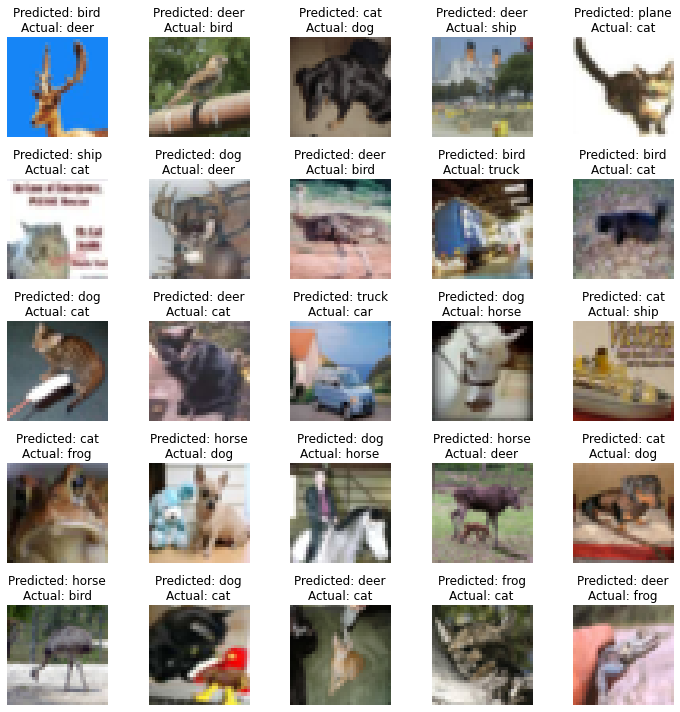

In [19]:
plot_misclassified_images(misclassified_imgs, classes, "misclassified_images1.png")

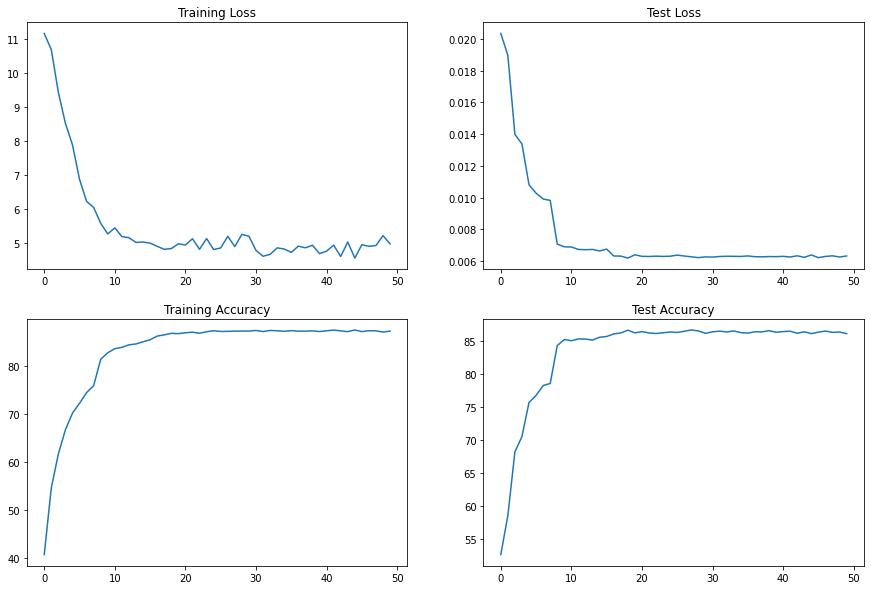

In [20]:
from results import plot_metrics
plot_metrics(train_loss, train_acc, test_loss, test_acc)

In [21]:
### GradCam

In [22]:
dataiter = iter(data.test_loader)
images, labels = dataiter.next()

In [23]:
import PIL
import numpy as np

In [24]:
# model.convblock

In [25]:
for name, layer in model.named_modules():
  if isinstance(layer, torch.nn.Conv2d):
    print(name, layer)

conv1 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.0.conv1 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.0.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.1.conv1 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.1.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.0.conv1 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
layer2.0.conv2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.0.shortcut.0 Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
layer2.1.conv1 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.1.conv2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer3.0.conv1 Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), 

In [26]:
def plot_images_gradcam(torch_img,normed_torch_img, model):
    images=[]
    g1 = GradCAM(model, model.layer1)
    g2 = GradCAM(model, model.layer2)
    g3 = GradCAM(model, model.layer3)
    g4 = GradCAM(model, model.layer4)
    mask1, _ = g1(normed_torch_img)
    mask2, _ = g2(normed_torch_img)
    mask3, _ = g3(normed_torch_img)
    mask4, _ = g4(normed_torch_img)
    heatmap1, result1 = visualize_cam(mask1, torch_img)
    heatmap2, result2 = visualize_cam(mask2, torch_img)
    heatmap3, result3 = visualize_cam(mask3, torch_img)
    heatmap4, result4 = visualize_cam(mask4, torch_img)

    images.extend([torch_img.cpu(), heatmap1, heatmap2, heatmap3, heatmap4])
    images.extend([torch_img.cpu(), result1, result2, result3, result4])
    grid_image = make_grid(images, nrow=5)
    imshow(grid_image)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


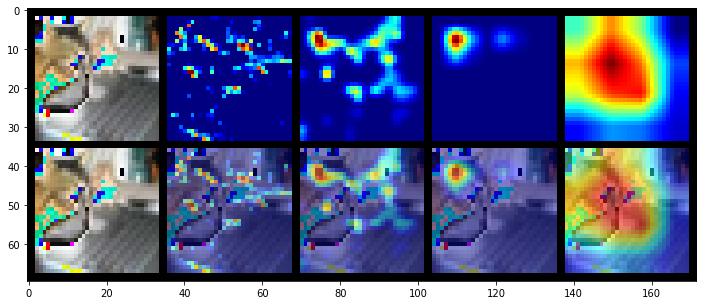

In [27]:
trans = transforms.ToPILImage()
pil_img=trans(torchvision.utils.make_grid(images[1]))
torch_img,normed_torch_img=change(pil_img,device)
plot_images_gradcam(torch_img,normed_torch_img, model)